In [1]:
# from IPython.core.display import HTML
# display(HTML('<style>.container { width:95% !important; } </style>'))

# %load_ext autoreload
# %autoreload 2

In [11]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from neural_exploration import *
# sns.set()

### Bandit settings

In [3]:
T = int(5000)
n_arms = 20
n_obs_features = 10
n_latent_features = 8
num_visibles = [1, n_latent_features//2, n_latent_features-1]
noise_std = 0.1

confidence_scaling_factor = noise_std

n_sim = 10

SEED = 103
np.random.seed(SEED)

### Neural network settings

In [4]:
p = 0.2
hidden_size = 24
epochs = 20
train_every = 10
use_cuda = False

In [5]:
### mean reward function
a = np.random.randn(n_latent_features)
a /= np.linalg.norm(a, ord=2)
a = a[:num_visibles[0]]
print(a)

[-0.41898753]


## Reward = Sigmoid

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
reward_func = lambda x: sigmoid(np.dot(a, x))

In [8]:

regret_dict = dict()

print("NeuralUCB-PO")
bandit = ContextualBandit(T=T, n_arms=n_arms, n_obs_features=n_obs_features, 
                          n_latent_features=n_latent_features,
                          h=reward_func, num_visibles=1,
                          noise_std=noise_std, seed=SEED, is_partial=True)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB_PO(bandit,
                      hidden_size=hidden_size,
                      reg_factor=2.,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.0001,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    regrets[i] = np.cumsum(model.regrets)
    
regret_dict['NeuralUCB-PO'] = regrets

print("NeuralUCB")
bandit = ContextualBandit(T=T, n_arms=n_arms, n_obs_features=n_obs_features, 
                          n_latent_features=n_latent_features,
                          h=reward_func, num_visibles=1,
                          noise_std=noise_std, seed=SEED)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=2.,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.0001,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    regrets[i] = np.cumsum(model.regrets)

regret_dict['NeuralUCB'] = regrets

NeuralUCB-PO
(5000, 20, 30)


100%|██████████| 5000/5000 [02:05<00:00, 39.81it/s, total regret=628, % optimal arm=63.02%]


NeuralUCB


100%|██████████| 5000/5000 [01:31<00:00, 54.77it/s, total regret=1.31e+3, % optimal arm=0.70%]


### Sublinear regret growth : the bandit problem is solved efficiently

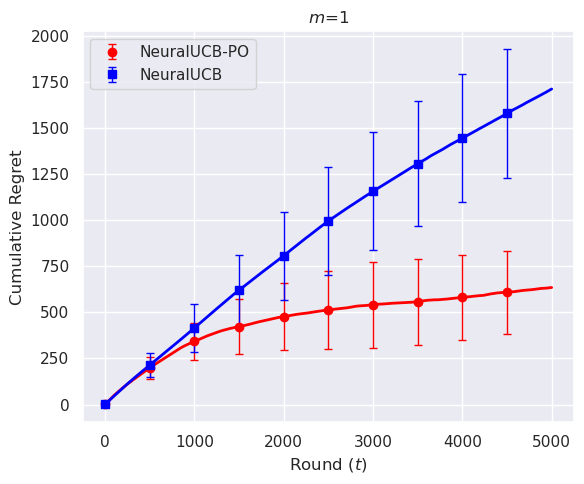

In [12]:
fig, ax = plt.subplots(figsize=(6, 5))

# 마커 스타일과 색상 설정
period = T // 10
markers = ['o', 's', '^', 'd', 'p']
colors = ['red', 'blue', 'green', 'orange', 'purple']
title = r"$m$"

# 각 알고리즘에 대해 에러바와 함께 그래프 그리기
for (marker, color), (key, item) in zip(zip(markers, colors), regret_dict.items()):
    rounds = np.arange(T)
    mean = np.mean(item, axis=0)
    std = np.std(item, axis=0, ddof=1)
    
    # 마커와 에러 바가 있는 라인을 주기적으로 표시
    ax.errorbar(rounds[::period], mean[::period], yerr=std[::period], label=key, 
                fmt=marker, color=color, capsize=3, elinewidth=1)
    
    # 주기적인 마커 없이 전체 라인을 표시
    ax.plot(rounds, mean, color=color, linewidth=2)

ax.grid(True)
ax.set_xlabel(r"Round ($t$)")
ax.set_ylabel("Cumulative Regret")
ax.set_title(f"{title}={1}")
ax.legend()

fig.tight_layout() 
fig.show()

In [10]:
bandit = ContextualBandit(T=T, n_arms=n_arms, n_obs_features=n_obs_features, 
                          n_latent_features=n_latent_features,
                          h=reward_func, num_visibles=1,
                          noise_std=noise_std, seed=SEED, is_partial=True)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB_PO(bandit,
                      hidden_size=hidden_size,
                      reg_factor=2.5,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.0001,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    regrets[i] = np.cumsum(model.regrets)

(5000, 20, 30)


100%|██████████| 5000/5000 [02:33<00:00, 32.47it/s, total regret=679, % optimal arm=43.62%]


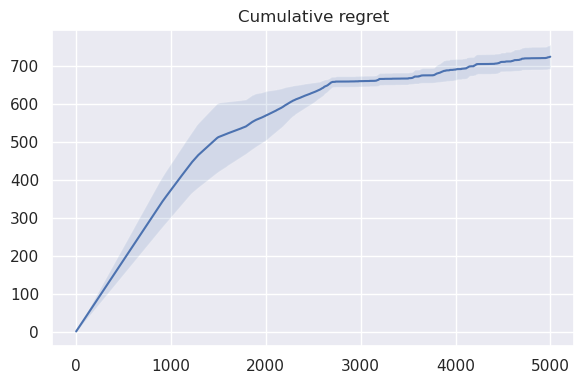

In [11]:
fig, ax = plt.subplots(figsize=(6, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(t, mean_regrets)
ax.fill_between(t, mean_regrets - std_regrets, mean_regrets + std_regrets, alpha=0.15)
    
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig.savefig('figures/neural_ucb_linear.pdf')

### NeuralUCB on quadratic rewards

In [8]:
### mean reward function
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
reward_func = lambda x: 100*np.dot(a, x)**2

In [9]:
bandit = ContextualBandit(T, n_arms, n_features, reward_func, noise_std=noise_std, seed=SEED)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda,
                     )
    model.run()
    regrets[i] = np.cumsum(model.regrets)

100%|██████████| 500/500 [00:15<00:00, 31.76it/s, total regret=1.26e+3, % optimal arm=78.80%]


### Sublinear regret growth : the bandit problem is solved efficiently (even though the reward is nonlinear!)

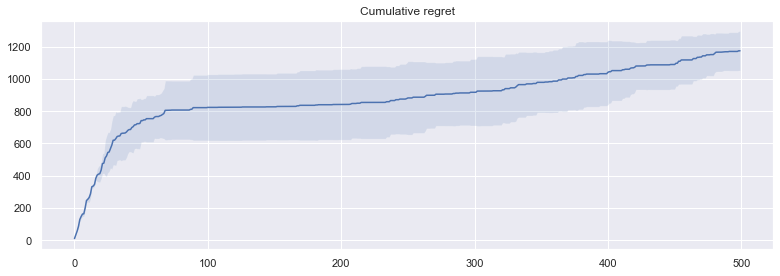

In [10]:
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(t, mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig.savefig('figures/neural_ucb_quad.pdf')

### NeuralUCB on nonlinear rewards

In [11]:
a = np.random.randn(n_features)
a /= np.linalg.norm(a, ord=2)
reward_func = lambda x: np.cos(2*np.pi*np.dot(x, a))

In [12]:
bandit = ContextualBandit(T, n_arms, n_features, reward_func, noise_std=noise_std, seed=SEED)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda,
                     )
    model.run()
    regrets[i] = np.cumsum(model.regrets)

100%|██████████| 500/500 [00:14<00:00, 35.51it/s, total regret=74.2, % optimal arm=66.20%]


### Sublinear regret growth : the bandit problem is solved efficiently (even though the reward is nonlinear!)

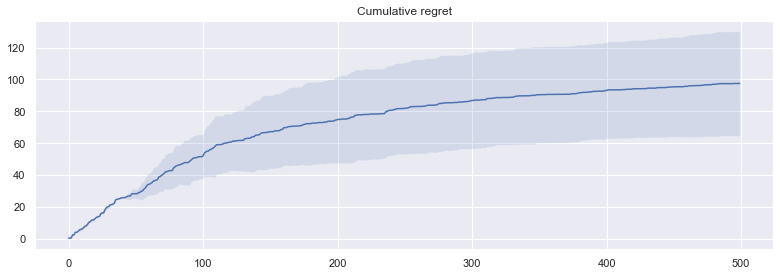

In [13]:
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

t = np.arange(T)

mean_regrets = np.mean(regrets, axis=0)
std_regrets = np.std(regrets, axis=0) / np.sqrt(regrets.shape[0])
ax.plot(t, mean_regrets)
ax.fill_between(t, mean_regrets - 2*std_regrets, mean_regrets + 2*std_regrets, alpha=0.15)
    
ax.set_title('Cumulative regret')

plt.tight_layout()
plt.show()

fig.savefig('figures/neural_ucb_cosine.pdf')